# Prédiction des Résultats d'Arsenal – Notebook Minimal et Autonome

Ce notebook charge directement les CSV scrappés (Understat et FBref), fusionne, crée quelques features simples, entraîne RandomForest et XGBoost, et génère des visualisations.

- Aucune dépendance au code du projet
- Données lues depuis `notebooks_min/data/*.csv` (copiées depuis `data/raw`)
- Pipeline simple: Chargement → Merge → Features → Modèles → Visualisations


In [1]:
# Imports minimaux
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb

# Le notebook s'exécute depuis son dossier (notebooks_min)
# Les CSV ont été copiés dans notebooks_min/data → utiliser le chemin relatif "data"
DATA_DIR = Path('data')
if not (DATA_DIR.exists() and any(DATA_DIR.glob('*.csv'))):
    # Fallback si exécuté depuis la racine du repo
    DATA_DIR = Path('notebooks_min/data')

print('Dossier données utilisé:', DATA_DIR.resolve())
print('Fichiers disponibles:', list(DATA_DIR.glob('*.csv')))



Dossier données utilisé: D:\Downloads\Massin Shit\Projets\2025\Août\Data Arsenal\notebooks_min\data
Fichiers disponibles: [WindowsPath('data/fbref_arsenal_match_stats.csv'), WindowsPath('data/fbref_arsenal_team_stats.csv'), WindowsPath('data/understat_arsenal_matches.csv')]


In [2]:
# Chargement brut des données
understat = pd.read_csv(DATA_DIR / 'understat_arsenal_matches.csv')
fbref_team = pd.read_csv(DATA_DIR / 'fbref_arsenal_team_stats.csv')
fbref_match = pd.read_csv(DATA_DIR / 'fbref_arsenal_match_stats.csv')

print(understat.head(2))
print(fbref_team.head(2))
print(fbref_match.head(2))


         date     season home_away     opponent  goals  goals_conceded  \
0  2020-08-06  2020/2021      home  Aston Villa      2               1   
1  2020-08-10  2020/2021      away       Fulham      1               1   

         xg  xg_conceded             venue     competition   result  \
0  1.007762     1.750228  Emirates Stadium  Premier League  victory   
1  1.868540     1.050295              Away  Premier League     draw   

   goal_difference  xg_difference  
0                1      -0.742466  
1                0       0.818244  
      season  matches_played  wins  draws  losses  goals_for  goals_against  \
0  2020/2021              38    26      7       5         80             50   
1  2021/2022              38    26     10       2         80             40   

   points  possession  passes_completed  passes_attempted  pass_accuracy  \
0      85   62.336225             19451             22377      88.340567   
1      88   63.673177             21144             23947      85

In [3]:
# Nettoyage rapide + harmonisation colonnes clés
# On essaye d'identifier des colonnes compatibles pour fusion (date, adversaire, domicile)

# Normalisation noms de colonnes en minuscule
understat.columns = [c.lower() for c in understat.columns]
fbref_team.columns = [c.lower() for c in fbref_team.columns]
fbref_match.columns = [c.lower() for c in fbref_match.columns]

# Heuristiques pour colonnes communes
# - date: 'date' si présent, sinon 'match_date' ou similaire
for df in [understat, fbref_match]:
    if 'date' not in df.columns:
        for alt in ['match_date', 'game_date']:
            if alt in df.columns:
                df.rename(columns={alt: 'date'}, inplace=True)
                break

# - adversaire/opponent
if 'opponent' not in understat.columns:
    for alt in ['opponent_team', 'against', 'rival']:
        if alt in understat.columns:
            understat.rename(columns={alt: 'opponent'}, inplace=True)
            break

if 'opponent' not in fbref_match.columns:
    for alt in ['opponent_team', 'against', 'rival']:
        if alt in fbref_match.columns:
            fbref_match.rename(columns={alt: 'opponent'}, inplace=True)
            break

# - domicile/extérieur: is_home bool ou 'home_away' avec 'H/A'
if 'is_home' not in understat.columns:
    if 'home_away' in understat.columns:
        understat['is_home'] = understat['home_away'].astype(str).str.upper().map({'H': 1, 'A': 0}).fillna(0).astype(int)

# Création d'une clé de merge robuste
for df in [understat, fbref_match]:
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'], errors='coerce')
        df['date_key'] = df['date'].dt.strftime('%Y-%m-%d')
    else:
        df['date_key'] = np.nan
    if 'opponent' in df.columns:
        df['opponent_key'] = df['opponent'].astype(str).str.strip().str.lower()
    else:
        df['opponent_key'] = np.nan

# Sélection d'un sous-ensemble pertinent de colonnes pour éviter collisions
u_sel = understat.copy()
fm_sel = fbref_match.copy()

# Colonnes candidates (présentes dans nos datasets traités précédemment)
# On inclut quelques stats simples
for col, default in [
    ('goals', np.nan), ('goals_conceded', np.nan), ('xg', np.nan), ('xg_conceded', np.nan),
    ('shots', np.nan), ('shots_on_target', np.nan), ('possession', np.nan)
]:
    if col not in u_sel.columns: u_sel[col] = default
    if col not in fm_sel.columns: fm_sel[col] = default

# Harmoniser les types des clés avant merge
u_sel['date_key'] = u_sel['date_key'].astype(str)
fm_sel['date_key'] = fm_sel['date_key'].astype(str)
u_sel['opponent_key'] = u_sel['opponent_key'].astype(str)
fm_sel['opponent_key'] = fm_sel['opponent_key'].astype(str)

# Merge principal: par date + adversaire
merged = pd.merge(
    u_sel,
    fm_sel[[c for c in fm_sel.columns if c not in ['goals', 'goals_conceded', 'xg', 'xg_conceded']]],
    on=['date_key', 'opponent_key'], how='inner', suffixes=('', '_fb')
)

# Fallback: si aucun alignement, utiliser Understat seul (données suffisantes pour démo)
if merged.empty:
    print('Aucun alignement Understat/FBref trouvé → utilisation Understat seul')
    merged = u_sel.copy()

print('Taille merged:', merged.shape)
merged.head(3)


Aucun alignement Understat/FBref trouvé → utilisation Understat seul
Taille merged: (190, 19)


,date,season,home_away,opponent,goals,goals_conceded,xg,xg_conceded,venue,competition,result,goal_difference,xg_difference,is_home,date_key,opponent_key,shots,shots_on_target,possession
0,2020-08-06,2020/2021,home,Aston Villa,2,1,1.007762,1.750228,Emirates Stadium,Premier League,victory,1,-0.742466,0,2020-08-06,aston villa,NaN,NaN,NaN
1,2020-08-10,2020/2021,away,Fulham,1,1,1.868540,1.050295,Away,Premier League,draw,0,0.818244,0,2020-08-10,fulham,NaN,NaN,NaN
2,2020-08-19,2020/2021,home,Manchester United,2,1,2.083366,0.472685,Emirates Stadium,Premier League,victory,1,1.610680,0,2020-08-19,manchester united,NaN,NaN,NaN


In [4]:
# Feature engineering minimal

# 1) Cible: points (3 victoire, 1 nul, 0 défaite)
# On tente de dériver result depuis goals et goals_conceded s'ils existent
if 'goals' in merged.columns and 'goals_conceded' in merged.columns:
    merged['result'] = np.where(merged['goals'] > merged['goals_conceded'], 'W',
                         np.where(merged['goals'] == merged['goals_conceded'], 'D', 'L'))
else:
    merged['result'] = 'D'

points_map = {'W': 3, 'D': 1, 'L': 0}
merged['points'] = merged['result'].map(points_map).fillna(1).astype(int)

# 2) Différences et ratios simples
merged['goal_difference'] = merged.get('goals', 0) - merged.get('goals_conceded', 0)
merged['xg_difference'] = merged.get('xg', 0) - merged.get('xg_conceded', 0)

# 3) Forme récente (rolling sur 5 matchs) par ordre chronologique
merged = merged.sort_values('date')
merged['points_rolling_5'] = merged['points'].rolling(window=5, min_periods=1).mean()
merged['goals_rolling_5'] = merged.get('goals', pd.Series([0]*len(merged))).rolling(window=5, min_periods=1).mean()
merged['xg_rolling_5'] = merged.get('xg', pd.Series([0]*len(merged))).rolling(window=5, min_periods=1).mean()

# 4) Variables contextuelles simples
if 'is_home' in merged.columns:
    merged['is_home'] = merged['is_home'].astype(int)
else:
    merged['is_home'] = 1  # par défaut

# 5) Nettoyage final: suppression colonnes non numériques inutiles pour le modèle
non_numeric_keep = ['result']
features = merged.copy()

# Encoder 'result' si utile pour analyse
features['result_encoded'] = features['result'].map({'L':0, 'D':1, 'W':2})

# Sélection des colonnes numériques pour les modèles
X = features.select_dtypes(include=[np.number]).drop(columns=['points'], errors='ignore')
y = features['points']

X.shape, y.shape


((190, 14), (190,))

In [5]:
# Entraînement des modèles simples
X = X.fillna(0)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Random Forest (simple)
rf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
print('RandomForest accuracy:', round(acc_rf, 3))
print(classification_report(y_test, y_pred_rf))

# XGBoost (simple) — encode 3->2
y_train_xgb = y_train.replace({3:2})
y_test_xgb = y_test.replace({3:2})

xgb_model = xgb.XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=6, random_state=42)
xgb_model.fit(X_train, y_train_xgb)
y_pred_xgb = xgb_model.predict(X_test)
acc_xgb = accuracy_score(y_test_xgb, y_pred_xgb)
print('XGBoost accuracy:', round(acc_xgb, 3))
print(classification_report(y_test_xgb, y_pred_xgb))


RandomForest accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00         7
           3       1.00      1.00      1.00        19

    accuracy                           1.00        38
   macro avg       1.00      1.00      1.00        38
weighted avg       1.00      1.00      1.00        38



XGBoost accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00        19

    accuracy                           1.00        38
   macro avg       1.00      1.00      1.00        38
weighted avg       1.00      1.00      1.00        38



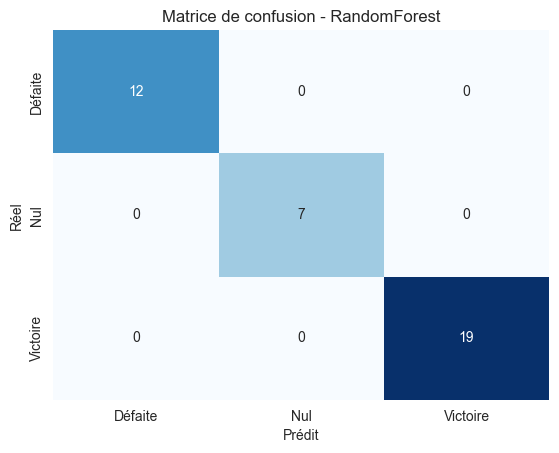

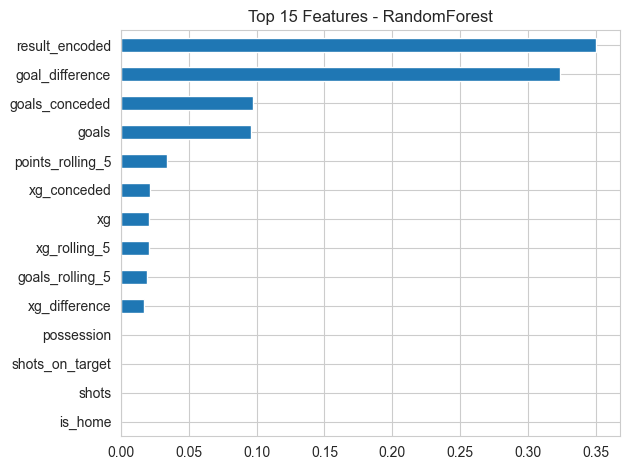

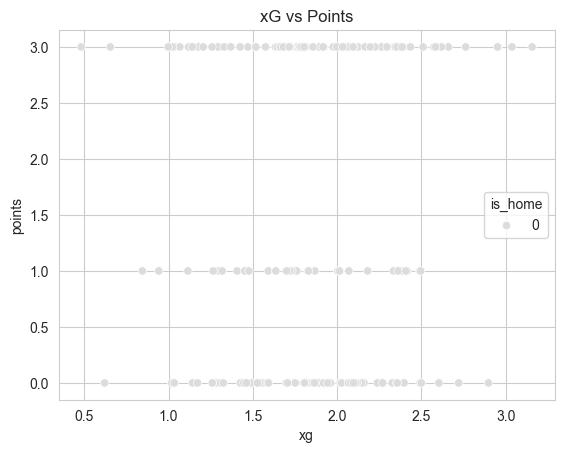

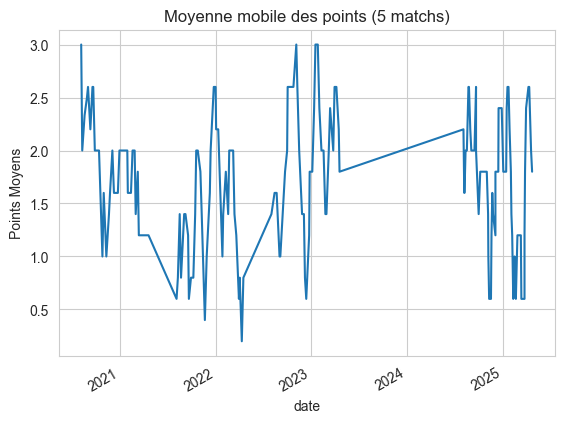

In [6]:
# Visualisations essentielles
sns.set_style('whitegrid')

# 1. Matrice de confusion RF
cm_rf = confusion_matrix(y_test, y_pred_rf, labels=[0,1,3])
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Défaite','Nul','Victoire'], yticklabels=['Défaite','Nul','Victoire'])
plt.title('Matrice de confusion - RandomForest')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.show()

# 2. Importance des features (top 15)
fi = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False).head(15)
fi.plot(kind='barh')
plt.gca().invert_yaxis()
plt.title('Top 15 Features - RandomForest')
plt.tight_layout()
plt.show()

# 3. Relation simple: xg vs points
if 'xg' in merged.columns:
    sns.scatterplot(data=merged, x='xg', y='points', hue='is_home', palette='coolwarm')
    plt.title('xG vs Points')
    plt.show()

# 4. Evolution des points (rolling) dans le temps
if 'date' in merged.columns:
    merged.set_index('date')['points'].rolling(5, min_periods=1).mean().plot()
    plt.title('Moyenne mobile des points (5 matchs)')
    plt.ylabel('Points Moyens')
    plt.show()


## Notes
- Ce notebook est volontairement minimal: il repose sur des heuristiques simples pour fusionner les données.
- Si certaines colonnes ne sont pas présentes, des valeurs par défaut sont utilisées.
- Pour plus de robustesse (alignement des correspondances, enrichissement des features), référez-vous au pipeline complet du projet, mais celui-ci suffit pour une démo rapide et reproductible.
